# Import python packages

In [1]:
import cv2
import os
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
from keras.models import Model
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator

from src.data import make_dataset
from src import metrics
from src import process_data
from src import models

#%load_ext autoreload # Load the "autoreload" extension so that code can change
#%autoreload 2 # always reload modules so that as you change code in src, it gets loaded

2024-04-08 17:23:54.330736: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-08 17:23:54.497658: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 17:23:54.497762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 17:23:54.502818: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-08 17:23:54.529011: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-08 17:23:54.531119: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Original image and its corresponding mask

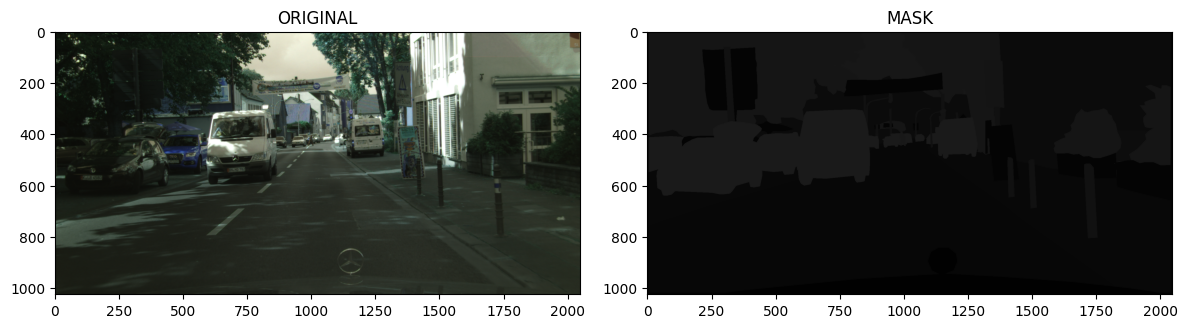

In [2]:
ORIGINAL_IMAGE_FOLDER = "/home/hao/repositories/design-autonomous-car/data/raw/leftImg8bit/train/cologne/"
MASK_IMAGE_FOLDER = "/home/hao/repositories/design-autonomous-car/data/raw/gtFine/train/cologne/"

ORIGINAL_IMAGE_NAME = "cologne_000000_000019_leftImg8bit.png"
MASK_IMAGE_NAME = "cologne_000000_000019_gtFine_labelIds.png"

ORIGINAL_IMAGE_PATH = os.path.join(ORIGINAL_IMAGE_FOLDER, ORIGINAL_IMAGE_NAME)
MASK_IMAGE_PATH = os.path.join(MASK_IMAGE_FOLDER, MASK_IMAGE_NAME)

# Loading image templates
ORIGINAL_IMAGE = cv2.imread(ORIGINAL_IMAGE_PATH)
MASK_IMAGE = cv2.imread(MASK_IMAGE_PATH)

# Plot and save image templates
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(ORIGINAL_IMAGE)
plt.title('ORIGINAL')

plt.subplot(1, 2, 2)
plt.imshow(MASK_IMAGE)
plt.title('MASK')

plt.tight_layout()
plt.savefig("./../reports/original_vs_mask.png")
plt.show()

In [3]:
dim_image = ORIGINAL_IMAGE.shape
dim_mask = MASK_IMAGE.shape

print("The images and masks have the following dimensions:", dim_image)

The images and masks have the following dimensions: (1024, 2048, 3)


# Dataset creation

In [4]:
dataset_path = "/home/hao/repositories/design-autonomous-car/data/processed/dataset/"
raw_images_path = "/home/hao/repositories/design-autonomous-car/data/raw/leftImg8bit/"
raw_masks_path = "/home/hao/repositories/design-autonomous-car/data/raw/gtFine/"

# source folders
raw_train_images = raw_images_path + "train/"
raw_val_images = raw_images_path + "val/"
raw_test_images = raw_images_path + "test/"
raw_train_masks = raw_masks_path + "train/"
raw_val_masks = raw_masks_path + "val/"
raw_test_masks = raw_masks_path + "test/"

# destination folders
train_images = dataset_path + "train_images/"
train_masks = dataset_path + "train_masks/"
val_images = dataset_path + "val_images/"
val_masks = dataset_path + "val_masks/"
test_images = dataset_path + "test_images/"
test_masks = dataset_path + "test_masks/"

In [ ]:
# Copy png files from source to destination 
make_dataset.copy_images(raw_train_images, train_images)
make_dataset.copy_images(raw_val_images, val_images)
make_dataset.copy_images(raw_test_images, test_images)
make_dataset.copy_images(raw_train_masks, train_masks)
make_dataset.copy_images(raw_val_masks, val_masks)
make_dataset.copy_images(raw_test_masks, test_masks)

In [4]:
# Keep only mask images 
make_dataset.keep_only_masks(dataset_path)

In [5]:
# Rename filename so that images and masks can match
make_dataset.rename_files(dataset_path)

In [16]:
# Keep only 20% of the dataset to save computer resources
#make_dataset.reduce_number_of_files(train_images, train_masks, 0.2)
#make_dataset.reduce_number_of_files(test_images, test_masks, 0.2)
#make_dataset.reduce_number_of_files(val_images, val_masks, 0.2)

# Deep Learning models

We will compare several image segmentation models. Here they are:
1. Unet Mini
2. VggNet

In [5]:
# List all files inside dataset
train_image_list = sorted(os.listdir(train_images))
train_mask_list = sorted(os.listdir(train_masks))
val_image_list = sorted(os.listdir(val_images))
val_mask_list = sorted(os.listdir(val_masks))
test_image_list = sorted(os.listdir(test_images))
test_mask_list = sorted(os.listdir(test_masks))

In [6]:
# Common parameters for all models
batch_size = 16
training_samples = len(train_image_list)
validation_samples = len(val_image_list)
filters_n = 16
train_steps = training_samples // batch_size
val_steps = validation_samples // batch_size

if len(train_image_list) % batch_size != 0:
    train_steps += 1
if len(val_image_list) % batch_size != 0:
    val_steps += 1

n_classes = 8
epochs = 30
channels = 3

In [7]:
# Predicted classes has a specific color
color_map = {
 '0': [0, 0, 0], # noir
 '1': [255, 255, 0], # jaune
 '2': [255, 0, 255], # magenta
 '3': [88, 41, 0], # marron
 '4': [0, 255, 0], # vert
 '5': [102, 0, 153], # violet
 '6': [255, 0, 0], # rouge
 '7': [0, 0, 255] # bleu
}

## Unet Mini model

In [8]:
# Input parameters for Unet Mini model
unet_mini_input_height = 256
unet_mini_input_width = 256

In [9]:
# Print model layers
model = models.unet_mini(n_classes, unet_mini_input_height, unet_mini_input_width, channels)
#tf.keras.utils.plot_model(model, "model.png")

In [ ]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = models.unet_mini(n_classes, unet_mini_input_height, unet_mini_input_width, channels)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[metrics.dice_coeff,
                                                                              metrics.dice_loss,
                                                                              metrics.total_loss,
                                                                              metrics.jaccard,
                                                                              'accuracy'])

train_gen = process_data.DataGenerator(train_images, train_image_list, unet_mini_input_height, unet_mini_input_width, batch_size)
val_gen = process_data.DataGenerator(val_images, val_image_list, unet_mini_input_height, unet_mini_input_width, batch_size)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_accuracy', mode='max', verbose=1),
        tf.keras.callbacks.TensorBoard(log_dir='logs', write_graph=True),
        tf.keras.callbacks.ModelCheckpoint(filepath='./../models/unet_mini.keras', monitor='val_accuracy', save_best_only='True', mode='max', verbose=1)
        ]

start_time = time.time()

history = model.fit(train_gen,
                    steps_per_epoch=train_steps,
                    epochs=epochs,
                    verbose=1,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    callbacks=callbacks)

end_time = time.time()
execution_time_unet_mini = end_time - start_time
print(f"Execution time: {execution_time_unet_mini} seconds")

In [10]:
# Load Unet_mini_model manually
unet_mini_model = load_model('./../models/unet_mini.keras',
                              custom_objects={
                                              'dice_coeff': metrics.dice_coeff,
                                              'dice_loss': metrics.dice_loss,
                                              'total_loss': metrics.total_loss,
                                              'jaccard': metrics.jaccard
                         })

1/1 [==============================] - 2s 2s/step


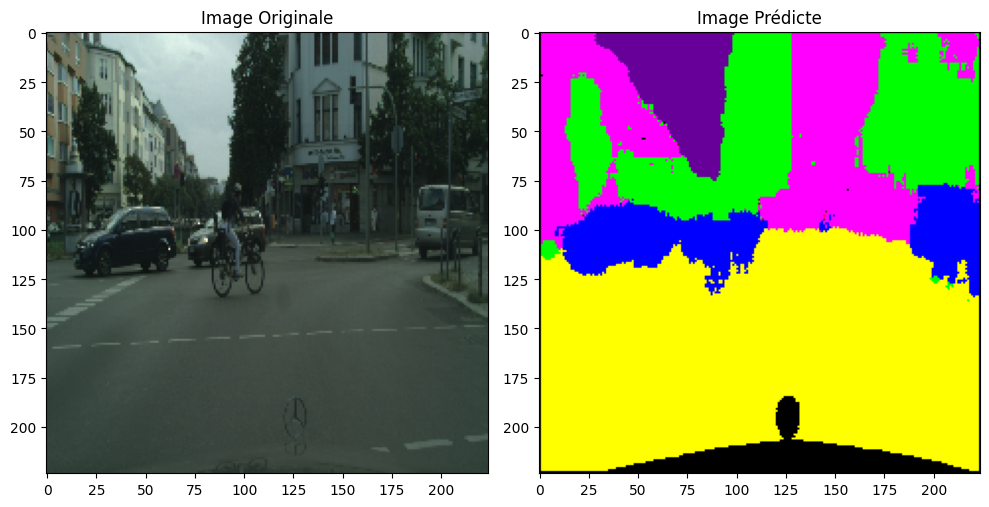

In [11]:
# Prediction of segmented image
img_path = test_images + test_image_list[0]
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)/255.
img_array = np.expand_dims(img_array, axis=0)

prediction = unet_mini_model.predict(img_array)

prediction = np.argmax(prediction, axis=-1)
prediction = np.squeeze(prediction, axis=0)
#prediction.shape

# Créer une image colorée basée sur les classes prédites
colored_image = np.zeros((224, 224, 3), dtype=np.uint8)

for class_index in range(8):
    mask = prediction == class_index
    colored_image[mask] = color_map[str(class_index)]
    
# Afficher le résultat
plt.figure(figsize=(10, 10))

# Afficher l'image originale
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(img))
plt.title('Image Originale')

# Afficher l'image segmentée
plt.subplot(1, 2, 2)
plt.imshow(colored_image)
plt.title('Image Prédicte')

plt.tight_layout()
plt.savefig("./../reports/original_vs_mask_unet_mini.png")

plt.show()

In [12]:
testing_samples = len(test_image_list)
test_steps = testing_samples // batch_size

if len(test_image_list) % batch_size != 0:
    test_steps += 1

test_gen = process_data.DataGenerator(test_images, test_image_list, unet_mini_input_height, unet_mini_input_width, batch_size)

result = unet_mini_model.evaluate(test_gen, steps=test_steps)
dict(zip(unet_mini_model.metrics_names, result))

/home/hao/repositories/design-autonomous-car/.venv/lib/python3.10/site-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


20/20 [==============================] - 39s 1s/step - loss: 0.5524 - dice_coeff: 0.4643 - dice_loss: 0.5357 - total_loss: 2.0137 - jaccard: 0.3024 - accuracy: 0.8386


{'loss': 0.552410364151001,
 'dice_coeff': 0.4643208086490631,
 'dice_loss': 0.5356791615486145,
 'total_loss': 2.0137362480163574,
 'jaccard': 0.3023647367954254,
 'accuracy': 0.8385671377182007}

## Vgg16 model

In [12]:
# Input parameters for Unet Mini model
vgg16_input_height = 224
vgg16_input_width = 224

In [13]:
# Print model layers
model = models.vgg16(vgg16_input_height, vgg16_input_width, n_filters=16, batchnorm=True, dropout=0.1)
#tf.keras.utils.plot_model(model, "model.png")

In [ ]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = models.vgg16(vgg16_input_height, vgg16_input_width, n_filters=16, batchnorm=True, dropout=0.1)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[metrics.dice_coeff,
                                                                              metrics.dice_loss,
                                                                              metrics.total_loss,
                                                                              metrics.jaccard,
                                                                              'accuracy'])

train_gen = process_data.DataGenerator(train_images, train_image_list, vgg16_input_height, vgg16_input_width, batch_size)
val_gen = process_data.DataGenerator(val_images, val_image_list, vgg16_input_height, vgg16_input_width, batch_size)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_accuracy', mode='max', verbose=1),
        tf.keras.callbacks.TensorBoard(log_dir='logs', write_graph=True),
        tf.keras.callbacks.ModelCheckpoint(filepath='./../models/vgg16.keras', monitor='val_accuracy', save_best_only='True', mode='max', verbose=1)
        ]

start_time = time.time()

history = model.fit(train_gen,
                    steps_per_epoch=train_steps,
                    epochs=epochs,
                    verbose=1,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    callbacks=callbacks)

end_time = time.time()
execution_time_vgg16 = end_time - start_time
print(f"Execution time: {execution_time_vgg16} seconds")

In [14]:
# Load vgg16_model manually
vgg16_model = load_model('./../models/vgg16.keras',
                         custom_objects={
                                         'dice_coeff': metrics.dice_coeff,
                                         'dice_loss': metrics.dice_loss,
                                         'total_loss': metrics.total_loss,
                                         'jaccard': metrics.jaccard
                        })

2024-04-08 17:26:29.081425: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 72253440 exceeds 10% of free system memory.
2024-04-08 17:26:29.258515: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44957696 exceeds 10% of free system memory.


1/1 [==============================] - 3s 3s/step


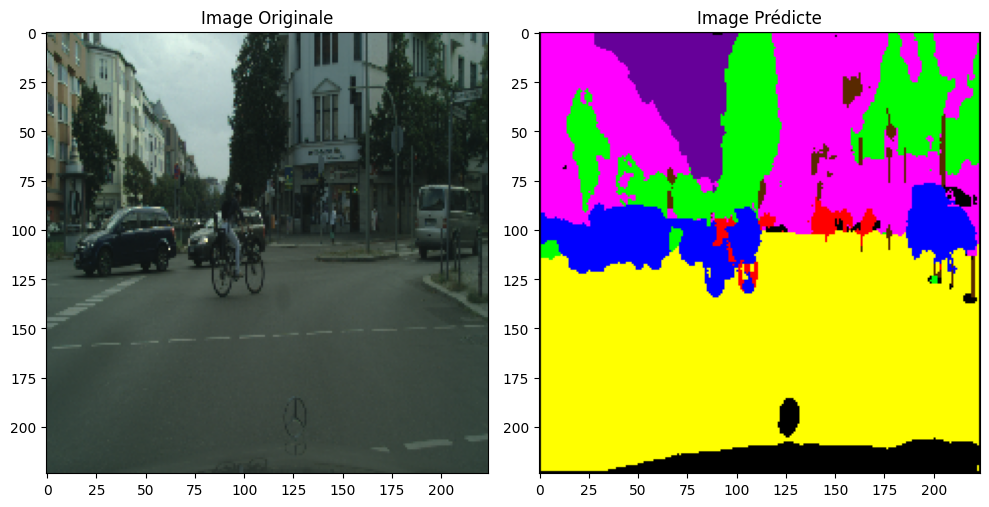

In [15]:
# Prediction of segmented image
img_path = test_images + test_image_list[0]
img = image.load_img(img_path, target_size=(vgg16_input_height, vgg16_input_width))
img_array = image.img_to_array(img)/255.
img_array = np.expand_dims(img_array, axis=0)

prediction = vgg16_model.predict(img_array)

prediction = np.argmax(prediction, axis=-1)
prediction = np.squeeze(prediction, axis=0)
#prediction.shape

# Créer une image colorée basée sur les classes prédites
colored_image = np.zeros((224, 224, 3), dtype=np.uint8)

for class_index in range(8):
    mask = prediction == class_index
    colored_image[mask] = color_map[str(class_index)]
    
# Afficher le résultat
plt.figure(figsize=(10, 10))

# Afficher l'image originale
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(img))
plt.title('Image Originale')

# Afficher l'image segmentée
plt.subplot(1, 2, 2)
plt.imshow(colored_image)
plt.title('Image Prédicte')

plt.tight_layout()
plt.savefig("./../reports/original_vs_mask_vgg16.png")

plt.show()

In [16]:
testing_samples = len(test_image_list)
test_steps = testing_samples // batch_size

if len(test_image_list) % batch_size != 0:
    test_steps += 1

test_gen = process_data.DataGenerator(test_images, test_image_list, vgg16_input_height, vgg16_input_width, batch_size)

result = vgg16_model.evaluate(test_gen, steps=test_steps)
dict(zip(vgg16_model.metrics_names, result))

/home/hao/repositories/design-autonomous-car/.venv/lib/python3.10/site-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(
2024-03-27 23:23:01.202346: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 513802240 exceeds 10% of free system memory.
2024-03-27 23:23:03.667531: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 719323136 exceeds 10% of free system memory.
2024-03-27 23:23:04.284654: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 513802240 exceeds 10% of free system memory.
2024-03-27 23:23:11.622190: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 513802240 exceeds 10% of free system memory.


 1/20 [>.............................] - ETA: 10:51 - loss: 0.2764 - dice_coeff: 0.8895 - dice_loss: 0.1105 - total_loss: 0.7408 - jaccard: 0.8010 - accuracy: 0.9152

2024-03-27 23:23:26.117707: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 513802240 exceeds 10% of free system memory.


20/20 [==============================] - 130s 5s/step - loss: 0.3754 - dice_coeff: 0.8662 - dice_loss: 0.1338 - total_loss: 0.8349 - jaccard: 0.7646 - accuracy: 0.8917


{'loss': 0.37539395689964294,
 'dice_coeff': 0.8661946058273315,
 'dice_loss': 0.13380537927150726,
 'total_loss': 0.83487468957901,
 'jaccard': 0.7646122574806213,
 'accuracy': 0.8917106986045837}